# Variational Autoencoder

In [1]:

import logging
from functools import partial

import pandas as pd
import sklearn
import torch
from fastai import learner
from fastai.basics import *
from fastai.callback.all import *
from fastai.callback.all import EarlyStoppingCallback
from fastai.learner import Learner
from fastai.torch_basics import *
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from torch.nn import Sigmoid

import pimmslearn
import pimmslearn.model
import pimmslearn.models as models
import pimmslearn.nb
from pimmslearn.analyzers import analyzers
from pimmslearn.io import datasplits
# overwriting Recorder callback with custom plot_loss
from pimmslearn.models import ae, plot_loss

learner.Recorder.plot_loss = plot_loss


logger = pimmslearn.logging.setup_logger(logging.getLogger('pimmslearn'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

pimmslearn - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
# training
epochs_max: int = 50  # Maximum number of epochs
batch_size: int = 64  # Batch size for training (and evaluation)
cuda: bool = True  # Whether to use a GPU for training
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 25
# A underscore separated string of layers, '256_128' for the encoder, reverse will be use for decoder
hidden_layers: str = '256_128'
# force_train:bool = True # Force training when saved model could be used. Per default re-train model
patience: int = 50  # Patience for early stopping
sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'VAE'  # model name
model_key: str = 'VAE'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
model = "VAE"
latent_dim = 10
batch_size = 64
epochs_max = 300
hidden_layers = "64"
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study"
model_key = "VAE"


Some argument transformations

In [5]:
args = pimmslearn.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/alzheimer_study',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'epochs_max': 300,
 'batch_size': 64,
 'cuda': False,
 'latent_dim': 10,
 'hidden_layers': '64',
 'patience': 50,
 'sample_idx_position': 0,
 'model': 'VAE',
 'model_key': 'VAE',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = pimmslearn.nb.args_from_dict(args)

if isinstance(args.hidden_layers, str):
    args.overwrite_entry("hidden_layers", [int(x)
                         for x in args.hidden_layers.split('_')])
else:
    raise ValueError(
        f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 64,
 'cuda': False,
 'data': Path('runs/alzheimer_study/data'),
 'epochs_max': 300,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'hidden_layers': [64],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'VAE',
 'model_key': 'VAE',
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'patience': 50,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID   protein groups                     
Sample_088  O43505                                22.371
Sample_156  A0A0A0MRJ7;P12259                     18.139
Sample_145  A0A0A0MTC8;Q9NQ36;Q9NQ36-2;Q9NQ36-3   14.681
Sample_119  P21810                                14.345
Sample_130  P01213                                16.853
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

pimmslearn - INFO     sample_id = 'Sample ID', single feature: index_column = 'protein groups'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,_collection site,_age at CSF collection,_gender,_t-tau [ng/L],_p-tau [ng/L],_Abeta-42 [ng/L],_Abeta-40 [ng/L],_Abeta-42/Abeta-40 ratio,_primary biochemical AD classification,_clinical AD diagnosis,_MMSE score
Sample ID,,,,,,,,,,,
Sample_000,Sweden,71.000,f,703.000,85.000,562.000,NaN,NaN,biochemical control,NaN,NaN
Sample_001,Sweden,77.000,m,518.000,91.000,334.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_002,Sweden,75.000,m,974.000,87.000,515.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_003,Sweden,72.000,f,950.000,109.000,394.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_004,Sweden,63.000,f,873.000,88.000,234.000,NaN,NaN,biochemical AD,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,Berlin,69.000,f,"1,945.000",NaN,699.000,"12,140.000",0.058,biochemical AD,AD,17.000
Sample_206,Berlin,73.000,m,299.000,NaN,"1,420.000","16,571.000",0.086,biochemical control,non-AD,28.000
Sample_207,Berlin,71.000,f,262.000,NaN,639.000,"9,663.000",0.066,biochemical control,non-AD,28.000


## Initialize Comparison

- replicates idea for truely missing values: Define truth as by using n=3 replicates to impute
  each sample
- real test data:
    - Not used for predictions or early stopping.
    - [x] add some additional NAs based on distribution of data

In [12]:
freq_feat = pimmslearn.io.datasplits.load_freq(args.data)
freq_feat.head()  # training data

protein groups
A0A024QZX5;A0A087X1N8;P35237                                                     197
A0A024R0T9;K7ER74;P02655                                                         208
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   185
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          208
A0A075B6H7                                                                        97
Name: freq, dtype: int64

### Produce some addional simulated samples

The validation simulated NA is used to by all models to evaluate training performance.

In [13]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,14.630
Sample_050,Q9Y287,15.755
Sample_107,Q8N475;Q8N475-2,15.029
Sample_199,P06307,19.376
Sample_067,Q5VUB5,15.309
...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822
Sample_002,A0A0A0MT36,18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525


In [14]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,"12,600.000"
mean,16.339
std,2.741
min,7.209
25%,14.412
50%,15.935
75%,17.910
max,30.140


## Data in wide format

- Autoencoder need data in wide format

In [15]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN


### Add interpolation performance

### Fill Validation data with potentially missing features

In [16]:
data.train_X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,NaN,17.705,17.039,NaN,16.413,19.102,...,NaN,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,NaN
Sample_206,15.798,17.554,15.600,15.938,NaN,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,NaN,15.345,17.084,18.708,NaN,19.433,NaN,NaN
Sample_207,15.739,NaN,15.469,16.898,NaN,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,NaN,18.725,16.138,19.599,13.637,11.174


In [17]:
data.val_y  # potentially has less features

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.863,NaN,NaN,NaN,NaN
Sample_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_002,NaN,14.523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_004,NaN,NaN,NaN,NaN,15.473,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.048,NaN,NaN,NaN,NaN,19.867,NaN,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.802
Sample_206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data.val_y = pd.DataFrame(pd.NA, index=data.train_X.index,
                          columns=data.train_X.columns).fillna(data.val_y)
data.val_y

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.863,NaN,NaN,NaN,NaN
Sample_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_002,NaN,14.523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_004,NaN,NaN,NaN,NaN,15.473,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.048,NaN,NaN,NaN,NaN,19.867,NaN,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.802
Sample_206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variational Autoencoder

### Analysis: DataLoaders, Model, transform

In [19]:
default_pipeline = sklearn.pipeline.Pipeline(
    [
        ('normalize', StandardScaler()),
        ('impute', SimpleImputer(add_indicator=False))
    ])

### Analysis: DataLoaders, Model

In [20]:

analysis = ae.AutoEncoderAnalysis(  # datasplits=data,
    train_df=data.train_X,
    val_df=data.val_y,
    model=models.vae.VAE,
    model_kwargs=dict(n_features=data.train_X.shape[-1],
                      n_neurons=args.hidden_layers,
                      # last_encoder_activation=None,
                      last_decoder_activation=None,
                      dim_latent=args.latent_dim),
    transform=default_pipeline,
    decode=['normalize'],
    bs=args.batch_size)
args.n_params = analysis.n_params_ae
if args.cuda:
    analysis.model = analysis.model.cuda()
analysis.model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1421, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=64, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=64, out_features=2842, bias=True)
  )
)

### Training



In [21]:
results = []
loss_fct = partial(models.vae.loss_fct, results=results)

In [22]:
analysis.learn = Learner(dls=analysis.dls,
                         model=analysis.model,
                         loss_func=loss_fct,
                         cbs=[ae.ModelAdapterVAE(),
                              EarlyStoppingCallback(patience=args.patience)
                              ])

analysis.learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE, CastToTensor]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : [ModelAdapterVAE]
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]

Adding a `EarlyStoppingCallback` results in an error.  Potential fix in
[PR3509](https://github.com/fastai/fastai/pull/3509) is not yet in
current version. Try again later

In [23]:
# learn.summary()

/home/runner/work/pimms/pimms/project/.snakemake/conda/6192e93206804e092b1c71b91535a817_/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

SuggestedLRs(valley=0.0030199517495930195)

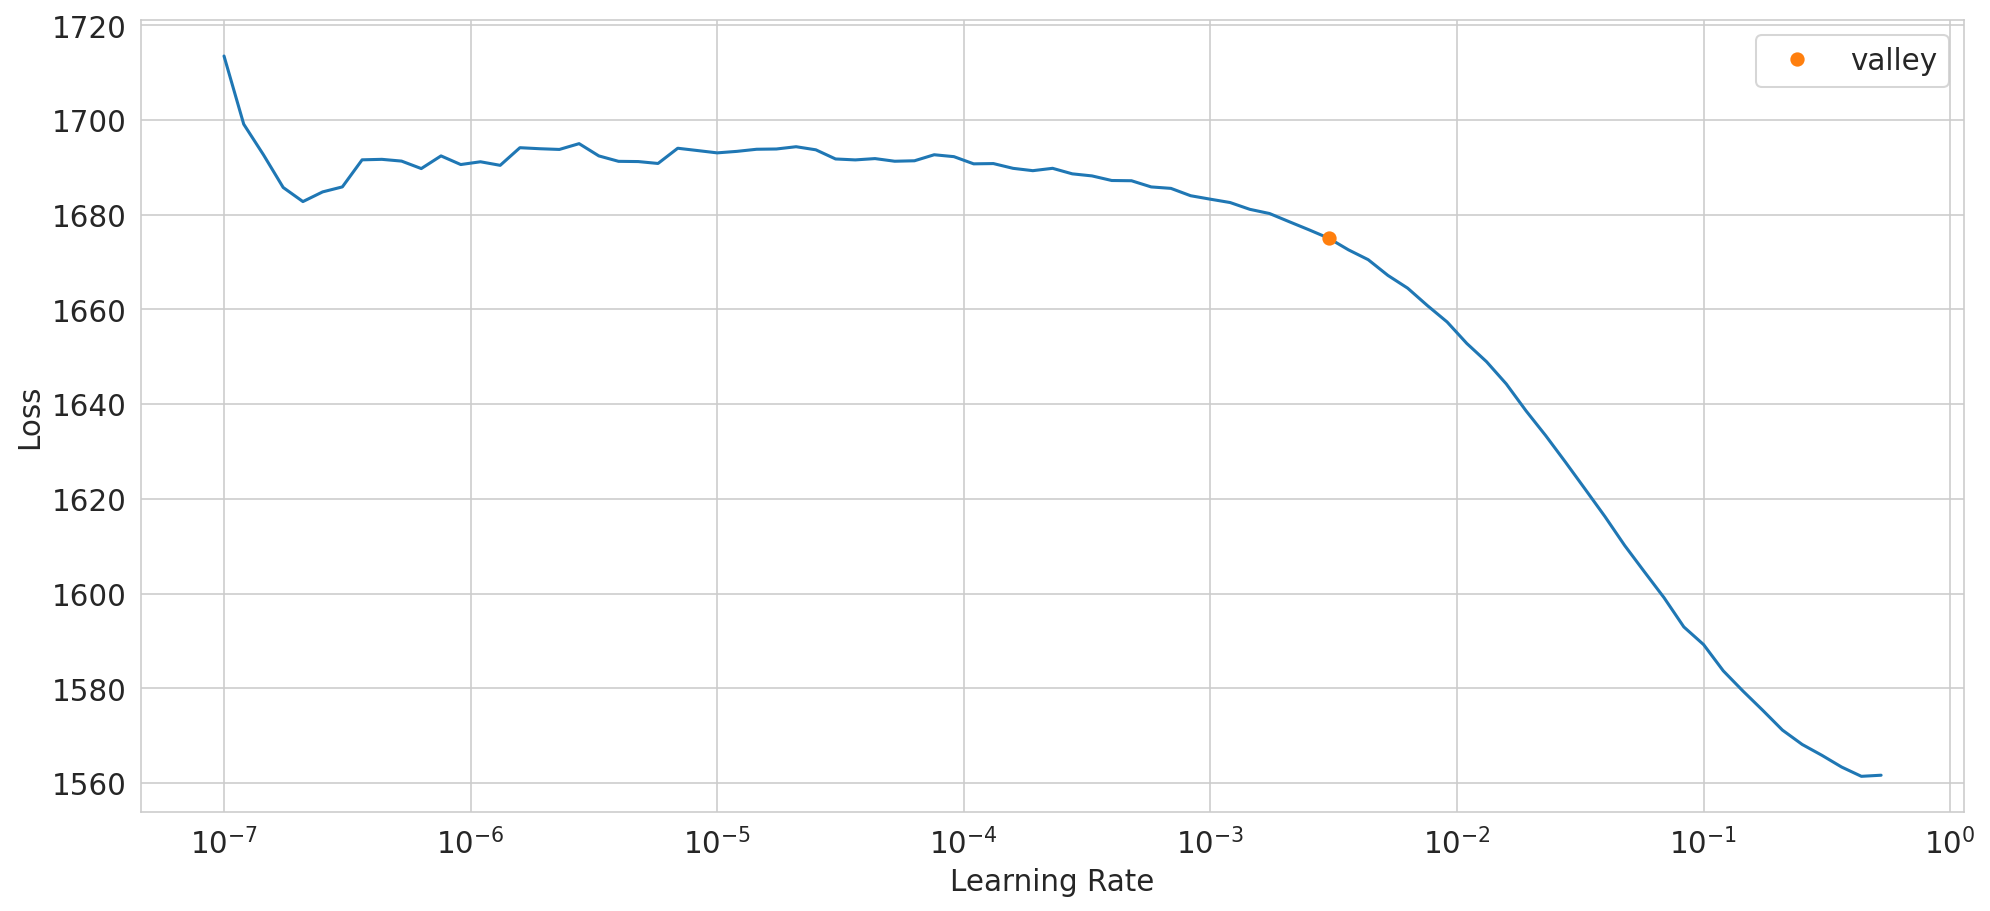

In [24]:
suggested_lr = analysis.learn.lr_find()
analysis.params['suggested_inital_lr'] = suggested_lr.valley
suggested_lr

In [25]:
results.clear()  # reset results

dump model config

In [26]:
# needs class as argument, not instance, but serialization needs instance
analysis.params['last_decoder_activation'] = Sigmoid()

pimmslearn.io.dump_json(
    pimmslearn.io.parse_dict(
        analysis.params, types=[
            (torch.nn.modules.module.Module, lambda m: str(m))
        ]),
    args.out_models / TEMPLATE_MODEL_PARAMS.format(args.model_key))

# restore original value
analysis.params['last_decoder_activation'] = Sigmoid

In [27]:
# papermill_description=train
analysis.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,1692.403320,93.383194,00:00
1,1685.492920,93.035828,00:00
2,1678.940796,93.220993,00:00
3,1681.327881,93.734573,00:00
4,1678.253662,94.357712,00:00
5,1675.629150,95.109261,00:00
6,1673.469238,94.266182,00:00
7,1670.552124,94.462387,00:00
8,1667.071045,95.034569,00:00
9,1664.305054,94.816536,00:00


No improvement since epoch 59: early stopping


Save number of actually trained epochs

In [28]:
args.epoch_trained = analysis.learn.epoch + 1
args.epoch_trained

110

#### Loss normalized by total number of measurements

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/vae_training


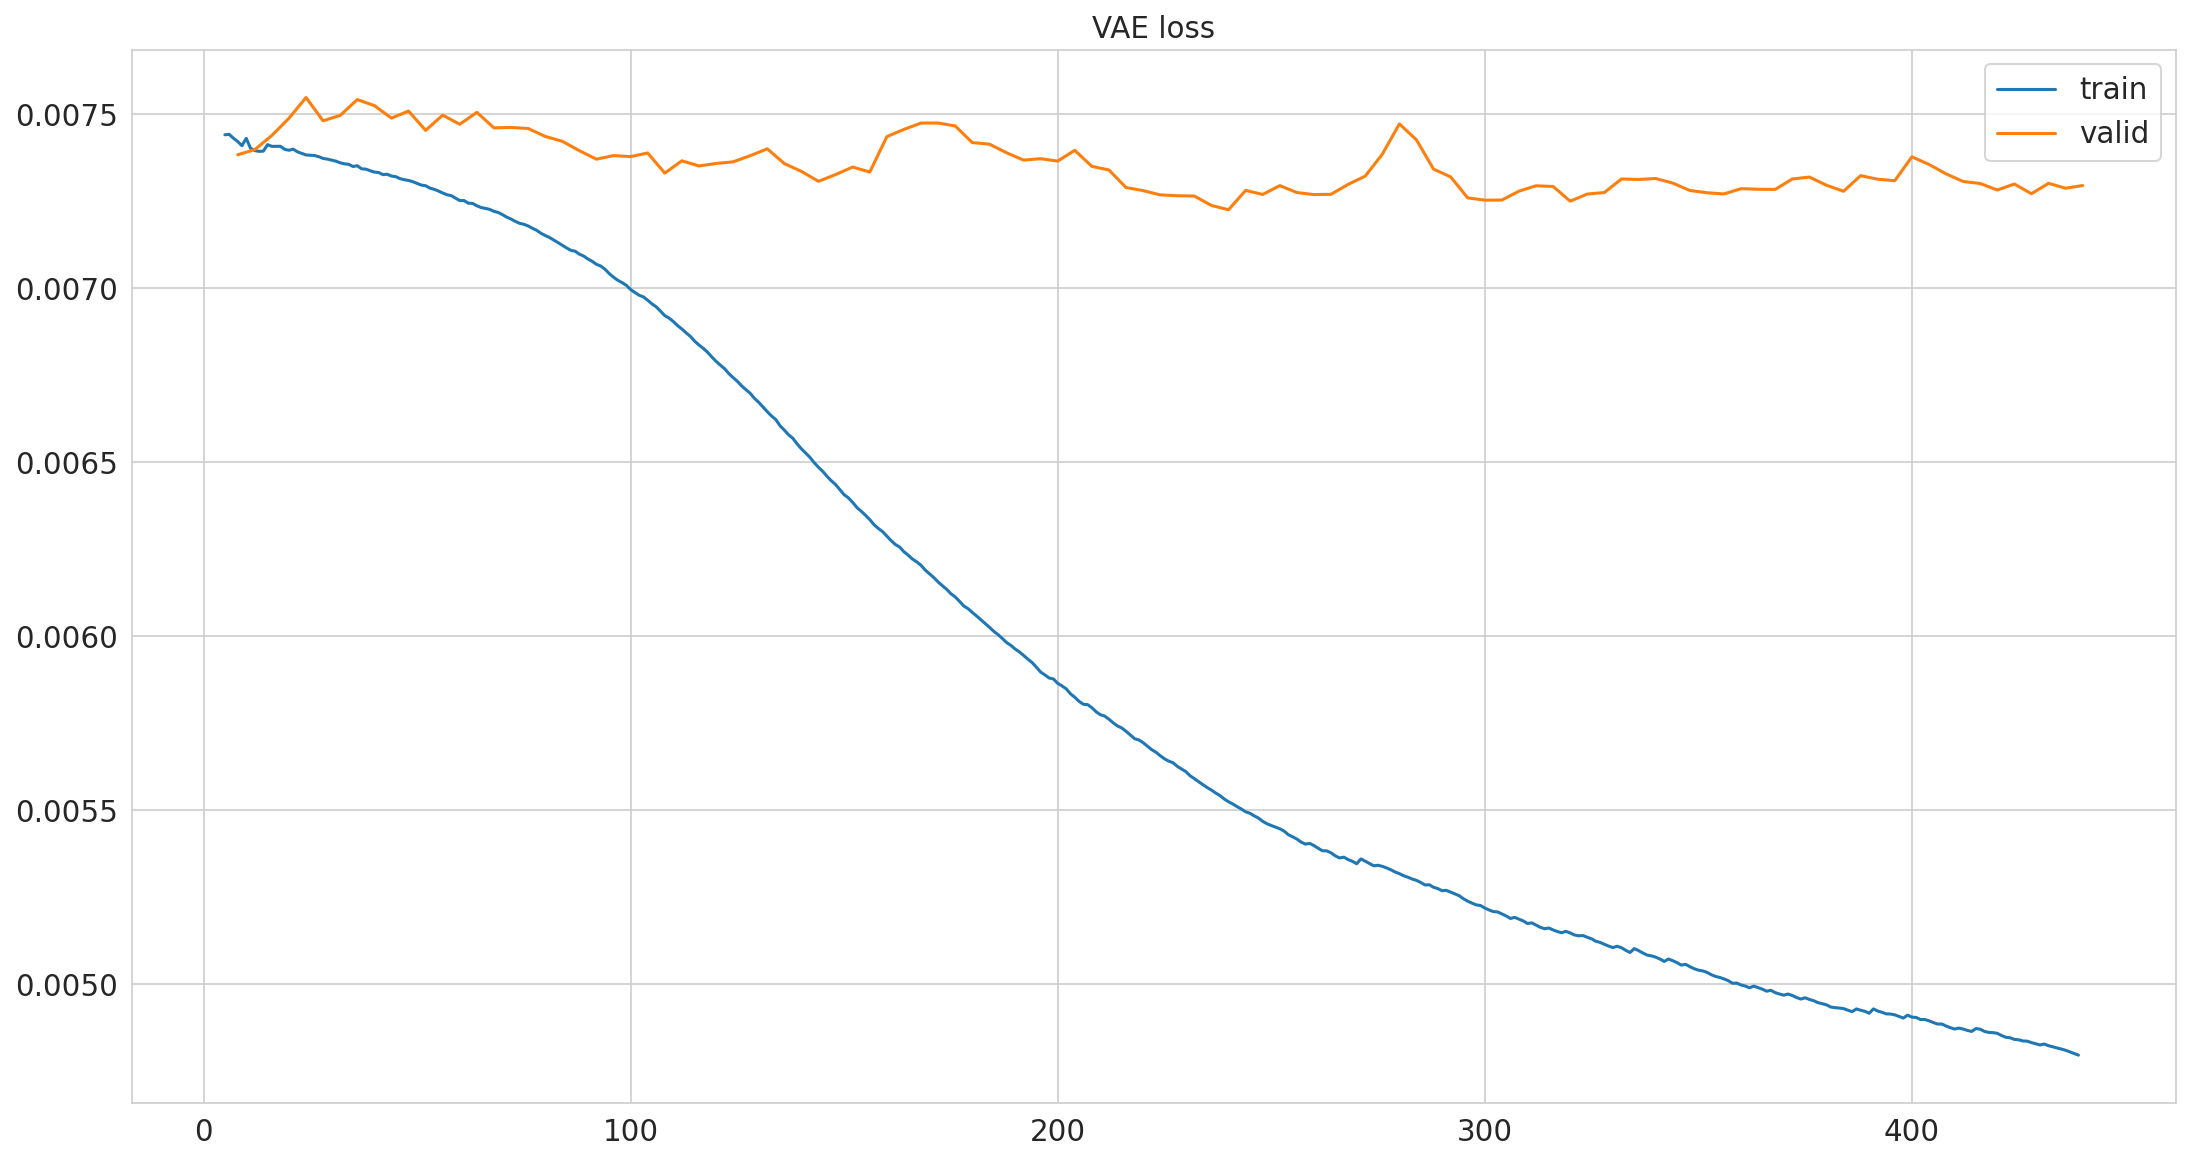

In [29]:
N_train_notna = data.train_X.notna().sum().sum()
N_val_notna = data.val_y.notna().sum().sum()
fig = models.plot_training_losses(analysis.learn, args.model_key,
                                  folder=args.out_figures,
                                  norm_factors=[N_train_notna, N_val_notna])

### Predictions
create predictions and select validation data predictions

In [30]:
analysis.model.eval()
pred, target = res = ae.get_preds_from_df(df=data.train_X, learn=analysis.learn,
                                          position_pred_tuple=0,
                                          transformer=analysis.transform)
pred = pred.stack()
pred

Sample ID   protein groups                                                                
Sample_000  A0A024QZX5;A0A087X1N8;P35237                                                     15.996
            A0A024R0T9;K7ER74;P02655                                                         16.511
            A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   15.905
            A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          16.729
            A0A075B6H7                                                                       16.941
                                                                                              ...  
Sample_209  Q9Y6R7                                                                           19.178
            Q9Y6X5                                                                           15.852
            Q9Y6Y8;Q9Y6Y8-2                                                                  19.411
         

In [31]:
val_pred_simulated_na['VAE'] = pred  # 'model_key' ?
val_pred_simulated_na

,,observed,VAE
Sample ID,protein groups,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.795
Sample_050,Q9Y287,15.755,16.651
Sample_107,Q8N475;Q8N475-2,15.029,14.911
Sample_199,P06307,19.376,18.955
Sample_067,Q5VUB5,15.309,15.056
...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.890
Sample_002,A0A0A0MT36,18.165,15.993
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,15.686


In [32]:
test_pred_simulated_na['VAE'] = pred  # model_key?
test_pred_simulated_na

observed  \
Sample ID  protein groups                                                        
Sample_000 A0A075B6P5;P01615                                            17.016   
           A0A087X089;Q16627;Q16627-2                                   18.280   
           A0A0B4J2B5;S4R460                                            21.735   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                              14.603   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4    16.143   
...                                                                        ...   
Sample_209 Q96ID5                                                       16.074   
           Q9H492;Q9H492-2                                              13.173   
           Q9HC57                                                       14.207   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                     14.962   
           Q9UGM5;Q9UGM5-2                                              16.871   

                                                                        VAE  
Sample ID  protein groups                                                    
Sample_000 A0A075B6P5;P01615                                         17.146  
           A0A087X089;Q16627;Q16627-2                                17.954  
           A0A0B4J2B5;S4R460                                         22.318  
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.207  
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.729  
...                                                                     ...  
Sample_209 Q96ID5                                                    15.944  
           Q9H492;Q9H492-2                                           13.382  
           Q9HC57                                                    14.331  
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.036  
           Q9UGM5;Q9UGM5-2                                           16.459  

[12600 rows x 2 columns]

save missing values predictions

In [33]:
if args.save_pred_real_na:
    pred_real_na = ae.get_missing_values(df_train_wide=data.train_X,
                                         val_idx=val_pred_simulated_na.index,
                                         test_idx=test_pred_simulated_na.index,
                                         pred=pred)
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Sample ID   protein groups          
Sample_000  A0A075B6J9                 15.462
            A0A075B6Q5                 16.069
            A0A075B6R2                 16.473
            A0A075B6S5                 16.285
            A0A087WSY4                 16.082
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   15.916
            Q9UI40;Q9UI40-2            16.208
            Q9UIW2                     16.780
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.241
            Q9UP79                     16.007
Name: intensity, Length: 46401, dtype: float32

### Plots

- validation data

In [34]:
analysis.model = analysis.model.cpu()
# underlying data is train_X for both
# assert analysis.dls.valid.data.equals(analysis.dls.train.data)
# Reconstruct DataLoader for case that during training singleton batches were dropped
_dl = torch.utils.data.DataLoader(
    pimmslearn.io.datasets.DatasetWithTarget(
        analysis.dls.valid.data),
    batch_size=args.batch_size,
    shuffle=False)
df_latent = pimmslearn.model.get_latent_space(analysis.model.get_mu_and_logvar,
                                              dl=_dl,
                                              dl_index=analysis.dls.valid.data.index)
df_latent

,latent dimension 1,latent dimension 2,latent dimension 3,latent dimension 4,latent dimension 5,latent dimension 6,latent dimension 7,latent dimension 8,latent dimension 9,latent dimension 10
Sample ID,,,,,,,,,,
Sample_000,-0.380,0.068,-0.215,-0.251,1.966,2.431,2.301,0.194,0.538,0.724
Sample_001,-0.431,-0.078,0.188,-1.236,1.819,2.615,0.666,-0.846,0.469,-0.499
Sample_002,2.098,-0.182,0.762,-0.684,0.439,2.154,1.327,-0.145,0.075,1.463
Sample_003,0.701,-0.362,-0.028,-0.677,1.095,2.603,2.238,0.181,1.159,1.138
Sample_004,-0.231,0.108,-0.219,-0.814,0.727,2.146,1.574,-0.613,1.133,0.983
...,...,...,...,...,...,...,...,...,...,...
Sample_205,0.639,0.986,1.554,-0.092,0.429,0.693,-0.479,0.843,2.435,1.129
Sample_206,0.568,1.614,1.817,1.316,1.874,-0.643,-0.088,-0.112,-1.986,0.678
Sample_207,-2.204,1.307,1.216,1.539,0.169,-0.137,1.397,0.226,1.111,0.654


In [35]:
ana_latent = analyzers.LatentAnalysis(df_latent,
                                      df_meta,
                                      args.model_key,
                                      folder=args.out_figures)
if args.meta_date_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_date'], ax = ana_latent.plot_by_date(
        args.meta_date_col)

In [36]:
if args.meta_cat_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_{"_".join(args.meta_cat_col.split())}'], ax = ana_latent.plot_by_category(
        args.meta_cat_col)

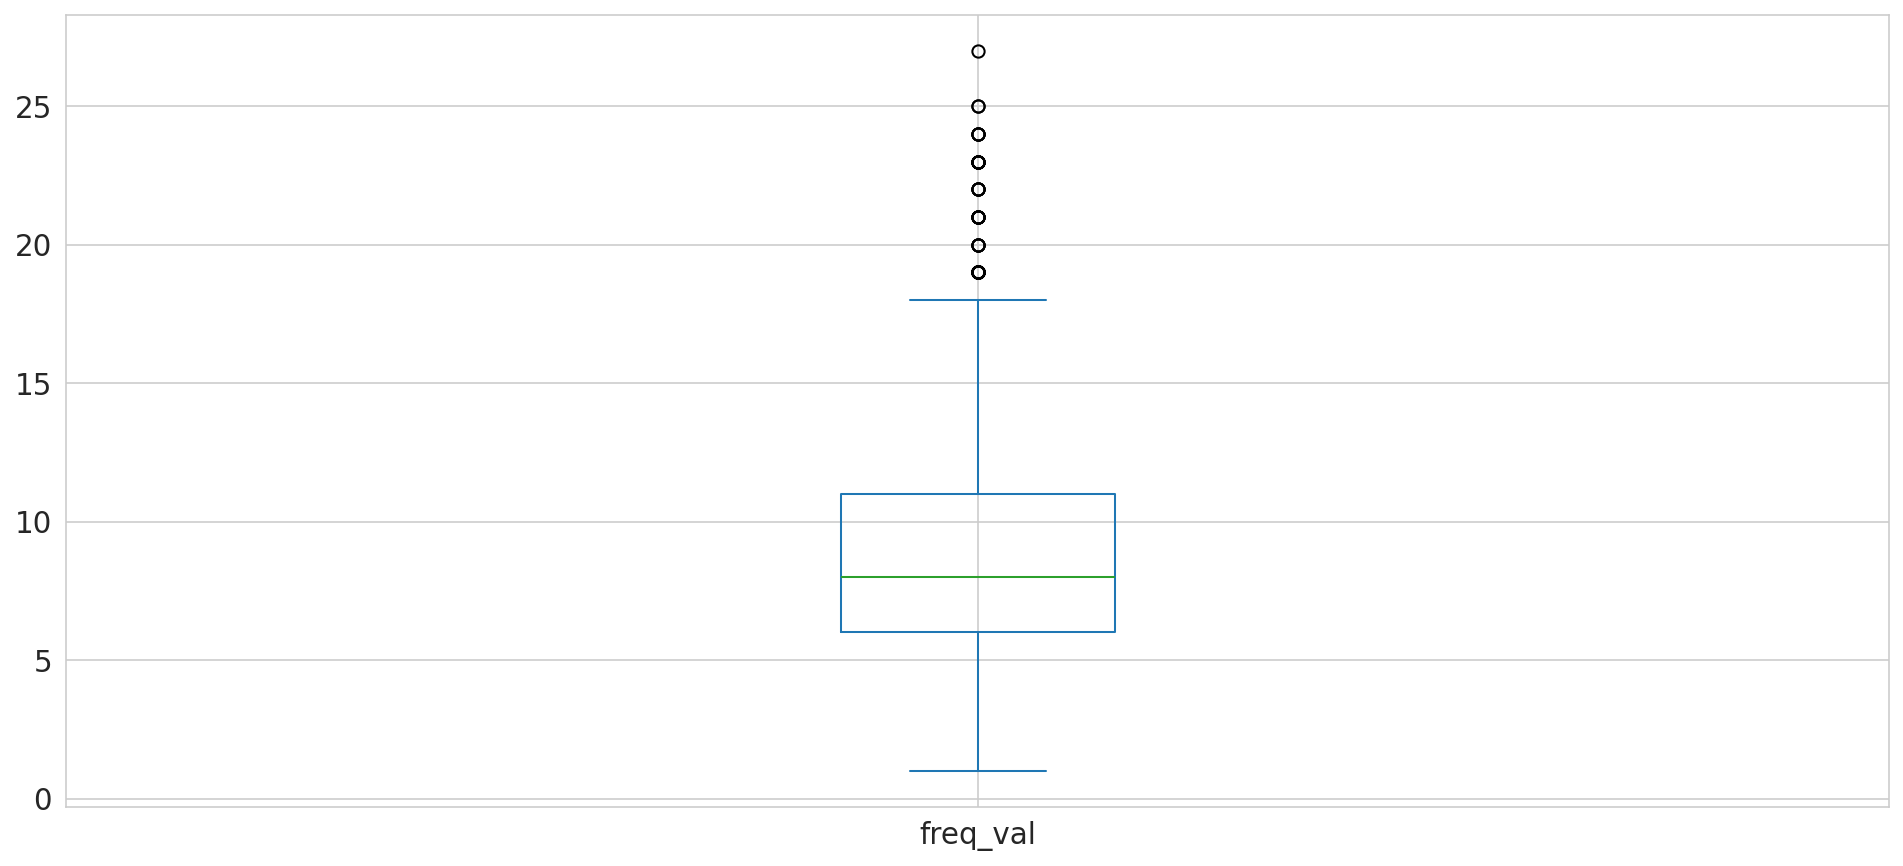

In [37]:
feat_freq_val = val_pred_simulated_na['observed'].groupby(level=-1).count()
feat_freq_val.name = 'freq_val'
ax = feat_freq_val.plot.box()

In [38]:
feat_freq_val.value_counts().sort_index().head()  # require more than one feat?

freq_val
1    12
2    18
3    50
4    82
5   108
Name: count, dtype: int64

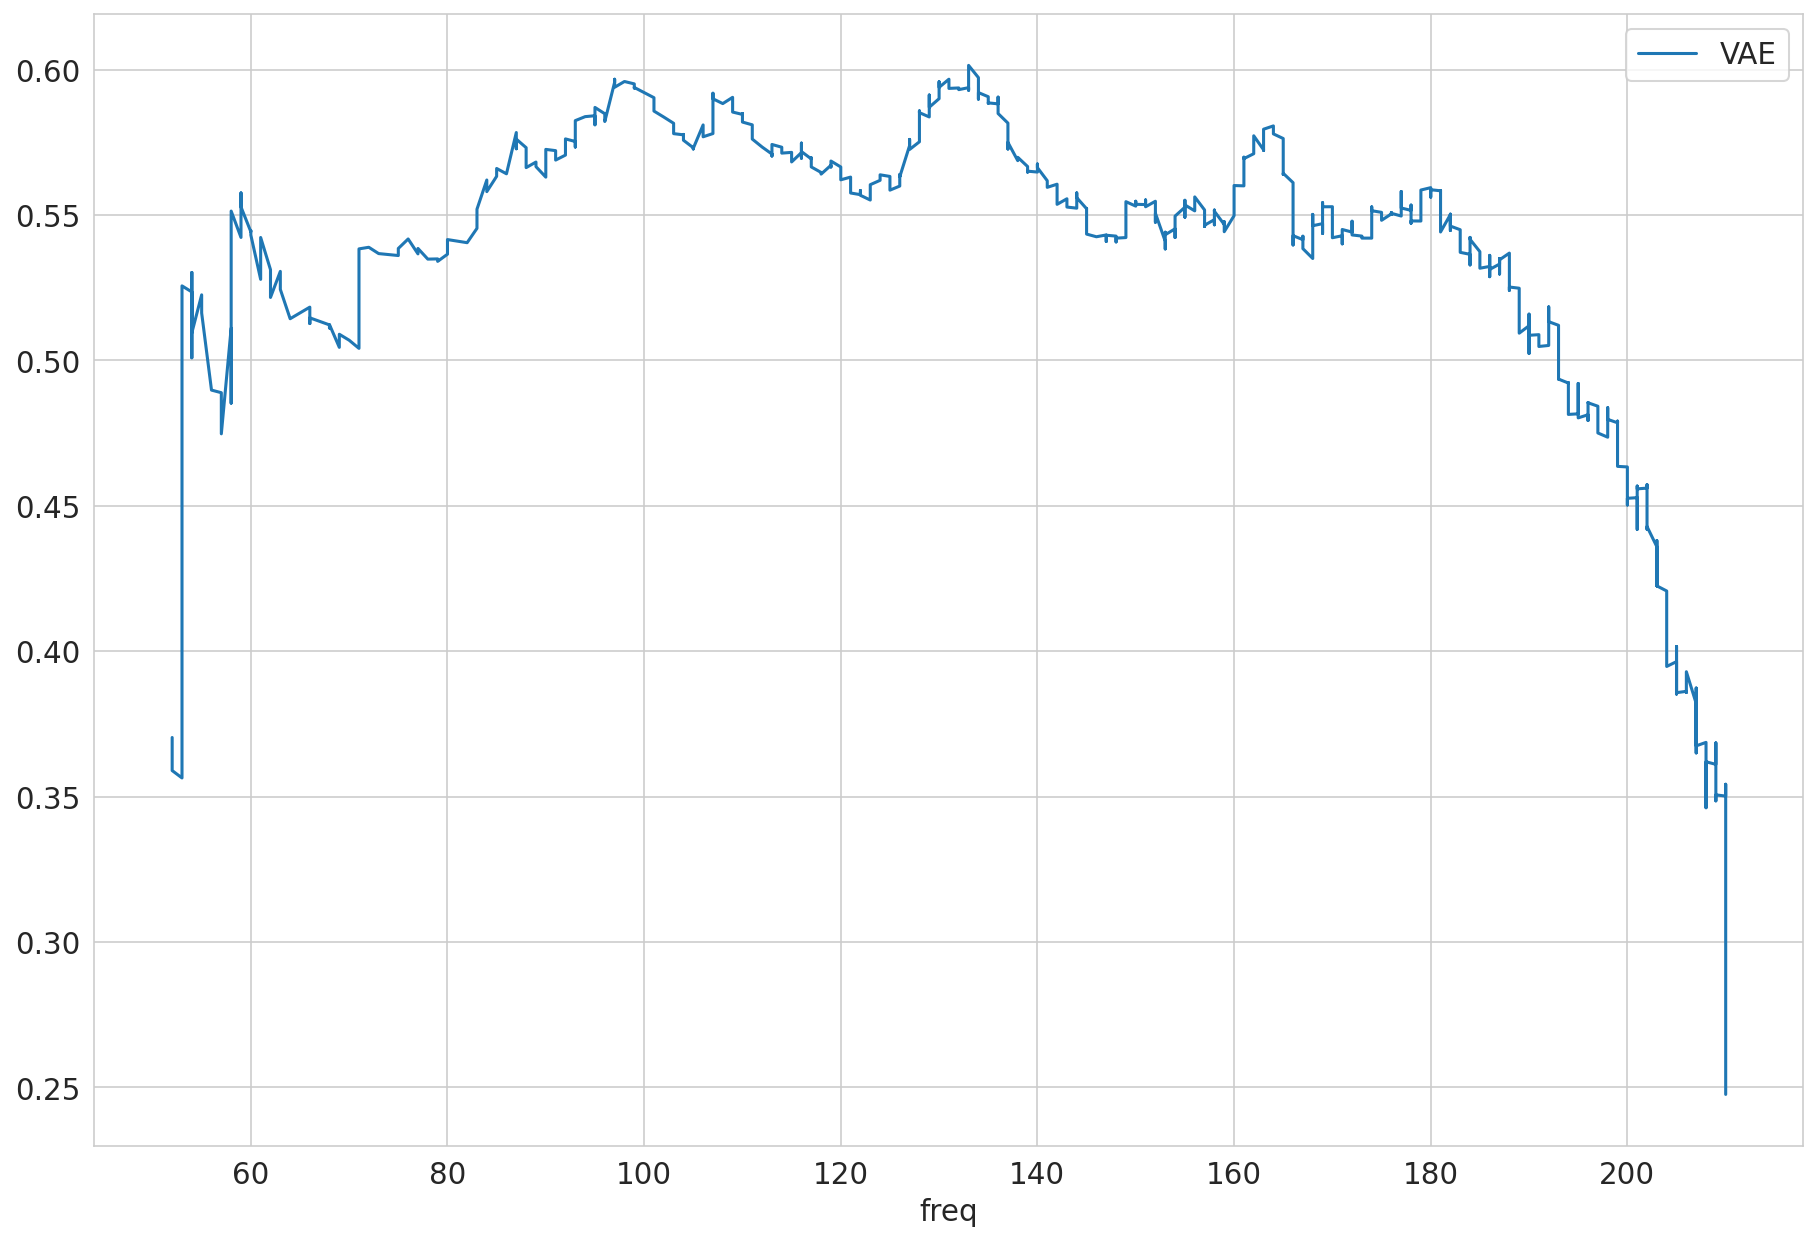

In [39]:
errors_val = val_pred_simulated_na.drop('observed', axis=1).sub(
    val_pred_simulated_na['observed'], axis=0)
errors_val = errors_val.abs().groupby(level=-1).mean()
errors_val = errors_val.join(freq_feat).sort_values(by='freq', ascending=True)


errors_val_smoothed = errors_val.copy()  # .loc[feat_freq_val > 1]
errors_val_smoothed[errors_val.columns[:-1]] = errors_val[errors_val.columns[:-1]
                                                          ].rolling(window=200, min_periods=1).mean()
ax = errors_val_smoothed.plot(x='freq', figsize=(15, 10))
# errors_val_smoothed

In [40]:
errors_val = val_pred_simulated_na.drop('observed', axis=1).sub(
    val_pred_simulated_na['observed'], axis=0)
errors_val.abs().groupby(level=-1).agg(['mean', 'count'])

VAE  \
                                                                                mean   
protein groups                                                                         
A0A024QZX5;A0A087X1N8;P35237                                                   0.156   
A0A024R0T9;K7ER74;P02655                                                       1.385   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8 0.270   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                        0.306   
A0A075B6H7                                                                     0.655   
...                                                                              ...   
Q9Y6R7                                                                         0.388   
Q9Y6X5                                                                         0.178   
Q9Y6Y8;Q9Y6Y8-2                                                                0.386   
Q9Y6Y9                                                                         0.469   
S4R3U6                                                                         0.487   

                                                                                      
                                                                               count  
protein groups                                                                        
A0A024QZX5;A0A087X1N8;P35237                                                       7  
A0A024R0T9;K7ER74;P02655                                                           4  
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8     9  
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                            6  
A0A075B6H7                                                                         6  
...                                                                              ...  
Q9Y6R7                                                                            10  
Q9Y6X5                                                                             7  
Q9Y6Y8;Q9Y6Y8-2                                                                    9  
Q9Y6Y9                                                                            15  
S4R3U6                                                                            24  

[1419 rows x 2 columns]

In [41]:
errors_val

,,VAE
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,1.165
Sample_050,Q9Y287,0.896
Sample_107,Q8N475;Q8N475-2,-0.119
Sample_199,P06307,-0.420
Sample_067,Q5VUB5,-0.253
...,...,...
Sample_111,F6SYF8;Q9UBP4,0.068
Sample_002,A0A0A0MT36,-2.172
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,0.160


## Comparisons

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

### Validation data

- all measured (identified, observed) peptides in validation data

In [42]:
# papermill_description=metrics
# d_metrics = models.Metrics(no_na_key='NA interpolated', with_na_key='NA not interpolated')
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [43]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'VAE': {'MSE': 0.46163572973844164,
  'MAE': 0.43270878003932917,
  'N': 12600,
  'prop': 1.0}}

### Test Datasplit


In [44]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'VAE': {'MSE': 0.48396517175660514,
  'MAE': 0.44003759303621104,
  'N': 12600,
  'prop': 1.0}}

Save all metrics as json

In [45]:
pimmslearn.io.dump_json(d_metrics.metrics, args.out_metrics /
                        f'metrics_{args.model_key}.json')
d_metrics

{ 'test_simulated_na': { 'VAE': { 'MAE': 0.44003759303621104,
                                  'MSE': 0.48396517175660514,
                                  'N': 12600,
                                  'prop': 1.0}},
  'valid_simulated_na': { 'VAE': { 'MAE': 0.43270878003932917,
                                   'MSE': 0.46163572973844164,
                                   'N': 12600,
                                   'prop': 1.0}}}

In [46]:
metrics_df = models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
VAE   MSE                       0.462              0.484
      MAE                       0.433              0.440
      N                    12,600.000         12,600.000
      prop                      1.000              1.000

## Save predictions

In [47]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [48]:
figures  # switch to fnames?

{}

In [49]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 1421,
 'batch_size': 64,
 'cuda': False,
 'data': Path('runs/alzheimer_study/data'),
 'epoch_trained': 110,
 'epochs_max': 300,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'hidden_layers': [64],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'VAE',
 'model_key': 'VAE',
 'n_params': 277998,
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'patience': 50,
 'sample_idx_position': 0,
 'save_pred_real_na': True}